# Табличный Q-learning

In [13]:
import numpy as np
import gym
import gc
import time
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook

class QTable:
    
    def __init__(self, env, N):
    
        self.pos_low, self.vel_low = env.observation_space.low
        self.pos_high, self.vel_high = env.observation_space.high
        self.pos_dfreq = abs(self.pos_low - self.pos_high)/(N[0] - 1)
        self.vel_dfreq = abs(self.vel_low - self.vel_high)/(N[1] - 1)
        self.table = np.zeros((env.action_space.n, N[0], N[1]))
        self.N = N[:]
    
    def __getitem__(self, idx):
        '''
        idx must have a form of (action, position, velocity)
        '''
        new_idx = (idx[0], 
                   int(abs(idx[1] - self.pos_low)//self.pos_dfreq), 
                   int(abs(idx[2] - self.vel_low)//self.vel_dfreq))
        return self.table[new_idx]
    
    def __setitem__(self, idx, value):
        new_idx = (idx[0], 
                   int(abs(idx[1] - self.pos_low)//self.pos_dfreq), 
                   int(abs(idx[2] - self.vel_low)//self.vel_dfreq))
        self.table[new_idx] = value
        
    def argmax(self, state):
        return np.argmax(self[:, state[0], state[1]])
    
    def max(self, state):
        return np.max(self[:, state[0], state[1]])
        
    def test(self, env, n_epochs, max_steps=200):
        self.rewards = []
        self.n_steps = []
        self.fpos = []
        for i in range(n_epochs):
            state = env.reset()
            curr_reward = 0
            for j in range(max_steps):
                action = self.argmax(state)
                new_state, reward, done, info = env.step(action)
                curr_reward += reward
                state = new_state
                if state[0] >= 0.5:
                    break
            self.rewards.append(curr_reward)
            self.n_steps.append(j)
            self.fpos.append(state[0])
        return self.rewards, self.n_steps, self.fpos
    
    def plot(self, env, n_epochs, max_steps = 300):
        result = self.test(self, env, n_epochs, max_steps=max_steps) #Change later
        fig, axarr = plt.subplots(1, 3, figsize=[20, 10])
        
        axarr[0].hist(result[0])
        axarr[0].set_title('Episode rewards')
        
        axarr[1].hist(result[1])
        axarr[1].set_title('Steps taken to complete episode')
        
        axarr[2].hist(result[2])
        axarr[2].set_title('Final position')

In [2]:
env = gym.make('MountainCar-v0')
env.reset()

array([-0.46976944,  0.        ])

In [148]:
'''
0 - right
1 - do nothing
2 - left
'''
env.action_space

Discrete(3)

In [149]:
print('Low')
print(env.observation_space.low)
print('High')
print(env.observation_space.high)

Low
[-1.2  -0.07]
High
[0.6  0.07]


In [4]:
#HYPERPARAMETERS
disc_vec = [500, 100]

n_epochs = 1000
steps_per_episode = 200

gamma = 0.95
learning_rate = 0.005

start_eps = 1
end_eps = 0.005
decay = 10e-5

max_pos = -1.2

In [182]:
qtab = QTable(env, disc_vec)

In [244]:
rewards = []
fpos = []
curr_step = 0
for i in tqdm_notebook(range(n_epochs)):
    
    if (i % 1000) == 1:
        print(f"Iteration {i}", rewards[-1], f'\nMax pos: {max_pos}')
    
    curr_reward = 0
    state = env.reset()
    
    for _ in range(steps_per_episode):
        
        curr_eps = end_eps + (start_eps - end_eps) * np.exp(-decay * curr_step)
        curr_step += 1
        
        if np.random.rand() > curr_eps:
            action = qtab.argmax(state)
        else:
            action = np.random.randint(0, 3)
            
        new_state, reward, done, info = env.step(action)
        
        reward = new_state[0] - 0.5
        
        if new_state[0] > max_pos:
            max_pos = new_state[0]
        
        if new_state[0] >= 0.5:
            reward += 2
        
        qtab[action, state[0], state[1]] = qtab[action, state[0], state[1]] +\
                                            learning_rate * (reward + gamma * qtab.max(new_state) -\
                                                            qtab[action, state[0], state[1]])
        
        state = new_state
        curr_reward += reward
        
        if done:
            break
        
    fpos.append(state[0]) 
    rewards.append(curr_reward)

Iteration 1 -204.00433689927496 
Max pos: 0.5270778407008053
Iteration 1001 -187.85088923126764 
Max pos: 0.5278456362842511
Iteration 2001 -193.38835542788541 
Max pos: 0.5278456362842511
Iteration 3001 -197.3554310817686 
Max pos: 0.5293064515955974
Iteration 4001 -183.56547752101008 
Max pos: 0.5293064515955974


KeyboardInterrupt: 

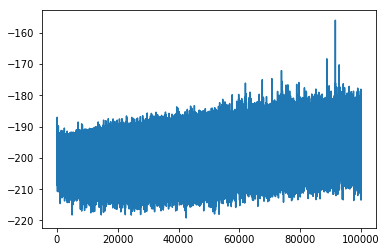

In [224]:
plt.plot(rewards)

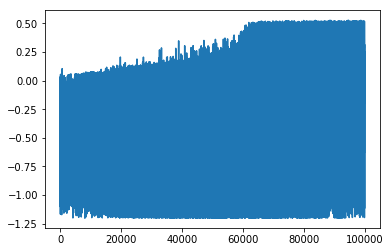

In [231]:
plt.plot(fpos)

In [249]:
hah = QTable.test(qtab, env, 300)

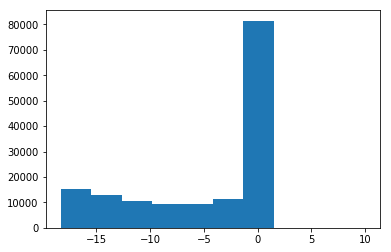

In [250]:
_ = plt.hist(qtab.table.flatten())

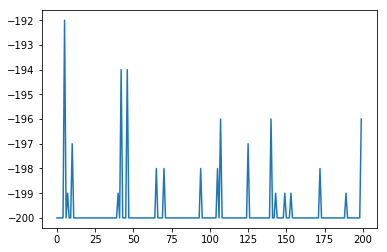

In [251]:
plt.plot(hah[0])

(array([  1.,   0.,   2.,   0.,   0.,   3.,   2.,   5.,   6., 181.]),
 array([191. , 191.8, 192.6, 193.4, 194.2, 195. , 195.8, 196.6, 197.4,
        198.2, 199. ]),
 <a list of 10 Patch objects>)

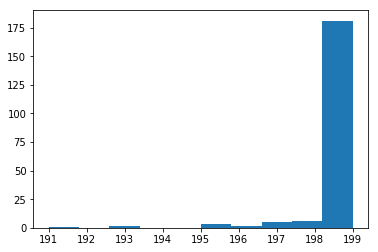

In [253]:
plt.hist(hah[1])

(array([ 1.,  3.,  4., 10., 13., 26., 47., 22., 22., 52.]),
 array([-0.56606498, -0.45767685, -0.34928872, -0.24090059, -0.13251246,
        -0.02412432,  0.08426381,  0.19265194,  0.30104007,  0.4094282 ,
         0.51781633]),
 <a list of 10 Patch objects>)

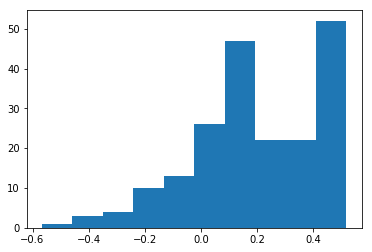

In [254]:
plt.hist(hah[2])

In [10]:
qtab = QTable(env, disc_vec)
qtab.table = np.load('MY_QTAB.npy')

In [11]:
state = env.reset()
for i in range(500):
    act = qtab.argmax(state)
    ns, _, done, _ = env.step(act)
    env.render()
    state = ns
    time.sleep(0.05)
    if state[0] >= 0.5:
        print(state)
        break

[0.51781633 0.02476672]


In [12]:
env.close()

In [267]:
env.step(1)

(array([0.6       , 0.00276073]), -1.0, True, {})